# Demand Restoration

In [837]:
import math
import random
import numpy as np
import pandas as pd


import optuna
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score



from sklearn.datasets import make_blobs
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [838]:
df = pd.read_csv('resultDataFeatured.csv')
pca_df = pd.read_csv('pca_resultDataFeatured.csv')

In [839]:
df.head()

,product_id,location_id,date,sales_qty,stock_qty,cost,promo,Demand,Deficit,NoFilter,...,NoFilter_lagforward28d_w28_nanmean,NoFilter_lagforward28d_w28_nanmedian,NoFilter_lagforward56d_alpha7d,NoFilter_lagforward56d_w14_nanmedian,NoFilter_lagforward56d_w56_nanmean,Promo_lagback7d_w56_pctl90,Promo_lagback28d_w14_nanmedian,Promo_lagback28d_w56_pctl90,Promo_lagback56d_w56_pctl90,Promo_lagforward56d_w14_nanmedian
0,9000400501,5637149154,2018-04-05,1.0,246,4.43,0,1.0,0,1,...,4.695652,4.0,3.830250,2.0,5.500000,0.0,0.0,0.0,0.0,2.0
1,9000400501,5637145510,2018-04-11,1.0,293,4.43,0,1.0,0,1,...,7.840000,6.0,2.233848,2.0,5.400000,0.0,0.0,0.0,0.0,2.0
2,9000400501,5637149154,2018-04-11,1.0,245,4.43,0,1.0,0,1,...,7.840000,6.0,2.233848,2.0,5.400000,0.0,0.0,0.0,0.0,2.0
3,9000400501,5637149154,2018-04-13,1.0,244,4.43,0,1.0,0,1,...,7.692308,6.0,2.937181,2.5,5.306122,0.0,0.0,0.0,0.0,2.5
4,9000400501,5637149154,2018-04-15,1.0,243,4.43,0,1.0,0,1,...,7.615385,6.0,2.965944,2.5,5.122449,0.0,0.0,0.0,0.0,2.5


## Метрики оценки

In [865]:
def calculate_metrics(y_test, y_pred):
    # Вычисление метрики MAE
    mae = mean_absolute_error(y_test, y_pred)
    #print('MAE: %.3f' % mae)
    
    # Вычисление метрики R2
    r2 = r2_score(y_test, y_pred)
    #print('R2: %.3f' % r2)
    
    # Вычисление метрики MAPE
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100.0
    #print('MAPE: %.3f' % mape)
    
    # Вычисление метрики sMAPE
    smape = np.mean(2.0 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred))) * 100.0
    #print('sMAPE: %.3f' % smape)
    
    # Вычисление метрики neg_root_mean_squared_error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    #print('RMSE: %.3f' % rmse)
    
    
    

    weights = list(range(1, len(y_test) + 1))
    denominator = np.dot(np.abs(y_test), weights)
    numerator = np.dot(np.abs(y_test - y_pred), weights)
    wape = (numerator / denominator) * 100.0
    
    
    
    std_p = np.std(y_pred)
    std_t = np.std(y_test)
    
    mean_p = np.mean(y_pred)
    mean_t = np.mean(y_test)
    
    #print('std_predict: %.3f & std_tesd: %.3f' % (std_p, std_t))
    #print('mean_predict: %.3f & mean_tesd: %.3f' % (mean_p, mean_t))
    
    
    return mae, r2, mape, smape, rmse, wape
    

In [864]:
list(range(1, len([1,2,3])+1))

[1, 2, 3]

In [841]:
def my_cross_val_score(model, X, y, cv=5):
    scores = (-cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')).sum() / 5
    return scores.mean()
    return "Mean score of %0.2f SMAPE" % (scores.mean())

## Тренировочная выборка

In [842]:
df_train_demand = df[df.Deficit == 0]

In [843]:
y = df_train_demand["Demand"]
X = df_train_demand.drop(columns=["Demand", 'date', 'sales_qty', 'stock_qty', 'Promo',
                                  'Deficit', 'NoFilter', 'NoneDeficit', 'product_id', 'location_id'], axis=1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808)

In [844]:
lag_features = list(X.columns)[6:]

In [845]:
numeric = ["cost"] + lag_features

categorical = [
    "day",
    "weekday",
    "month",
    "year",
    'promo'
    
]

In [846]:
column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric),
    ]
)

### Выбор гиперпараметров

In [847]:
def objective(trial):
    y = df_train_demand["Demand"]
    X = df_train_demand.drop(columns=["Demand", 'date', 'sales_qty', 'stock_qty', 'Promo',
                                  'Deficit', 'NoFilter', 'NoneDeficit', 'product_id', 'location_id'], axis=1)
    
    

    pipeline = Pipeline(
        steps=[
            ("ohe_and_scaling", column_transformer),
        ]
    )

    X = pipeline.fit_transform(X, y)
    

    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=808
    )

    

    param = {
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.17, 0.2, 0.22, 0.26, 0.28, 0.31]
        ),
        "n_estimators": 4000,
        "max_depth": trial.suggest_categorical("max_depth", [3, 4, 5, 6]),
        "random_state": trial.suggest_categorical(
            "random_state", [24, 808, 2020]
        ),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 300),
    }
    model = xgb.XGBRegressor(**param)
    
    model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        early_stopping_rounds=100,
        verbose=False,
    )
    preds = model.predict(test_x)
    smape_error = my_smape(preds, test_y)

    return smape_error

In [849]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)



[I 2023-05-31 18:57:54,058] A new study created in memory with name: no-name-ed930d6e-94c3-4a35-8a9b-403acf0022ac
[I 2023-05-31 18:57:54,715] Trial 0 finished with value: 62.41066665422864 and parameters: {'lambda': 0.009748622974324049, 'alpha': 0.004947866968390512, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.22, 'max_depth': 3, 'random_state': 24, 'min_child_weight': 14}. Best is trial 0 with value: 62.41066665422864.
[I 2023-05-31 18:57:55,555] Trial 1 finished with value: 57.240876203319864 and parameters: {'lambda': 2.7984871951113304, 'alpha': 0.0015324033565578456, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.31, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 42}. Best is trial 1 with value: 57.240876203319864.
[I 2023-05-31 18:57:56,052] Trial 2 finished with value: 60.05550976498266 and parameters: {'lambda': 5.1971909601579, 'alpha': 0.4319836767563194, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2, 'max_depth': 4

Number of finished trials: 5
Best trial: {'lambda': 2.7984871951113304, 'alpha': 0.0015324033565578456, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.31, 'max_depth': 5, 'random_state': 24, 'min_child_weight': 42}


In [876]:
def individual_training(product_ids, location_ids, df_train_demand, model):
    mae_, r2_, mape_, smape_, rmse_, wape_ = [],[],[],[],[],[]
    for location in location_ids:
        for product in product_ids:
            
            
            df_train_demand_ = df_train_demand[(df_train_demand.product_id == product) & (df_train_demand.location_id == location)]
            
            if len(df_train_demand_ ) != 0:
                y = df_train_demand_["Demand"]
                X = df_train_demand_.drop(columns=["Demand", 'date', 'sales_qty', 'stock_qty', 'Promo',
                                                  'Deficit', 'NoFilter', 'NoneDeficit', 'product_id', 'location_id'], axis=1)
                y = y.reset_index(drop=True)
                X = X.fillna(0)

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  


                xgb_cool = model

                xgb_cool.fit(X_train,y_train)

                y_predict = xgb_cool.predict(X_test)
                mae, r2, mape, smape, rmse, wape = calculate_metrics(y_predict, y_test)
                
                mae_.append(mae)
                r2_.append(r2)
                mape_.append(mape)
                smape_.append(smape)
                rmse_.append(rmse)
                wape_.append(wape)
                #accuracy_.append(accuracy)
    
    
    
    
    print("MAE: %.3f" % np.nanmean(mae_))
    print("R2: %.3f" % np.nanmean(r2_))
    print("MAPE_: %.3f" % np.nanmean(mape_))
    print("SMAPE_: %.3f" % np.nanmean(smape_))
    print("RMSE_: %.3f" % np.nanmean(rmse_))
    print("WAPE_: %.3f" % np.nanmean(wape_))
                
def massive_training(df_train_demand, model):
    
    df_train_demand_ = df_train_demand.copy()


    y = df_train_demand_["Demand"]
    X = df_train_demand_.drop(columns=["Demand", 'date', 'sales_qty', 'stock_qty', 'Promo',
                                      'Deficit', 'NoFilter', 'NoneDeficit', 'product_id', 'location_id'], axis=1)
    y = y.reset_index(drop=True)
    X = X.fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)  


    xgb_cool = model

    xgb_cool.fit(X_train,y_train)

    y_predict = xgb_cool.predict(X_test)
    mae, r2, mape, smape, rmse, wape = calculate_metrics(y_predict, y_test)
    
    
    print("MAE: %.3f" % mae)
    print("R2: %.3f" % r2)
    print("MAPE_: %.3f" % mape)
    print("SMAPE_: %.3f" % smape)
    print("RMSE_: %.3f" % rmse)
    print("WAPE_: %.3f" % wape)

    
def rolling_mean(product_ids, location_ids,window_size, data):
    mae_, r2_, mape_, smape_, rmse_, wape_ = [],[],[],[],[], []
    for location in location_ids:
        for product in product_ids:
    
            df = data[(data.product_id == product) 
                                               & (data.location_id == location)].sort_values(by='date')


            # вычисляем скользящее среднее и добавляем в таблицу
            df['RollingMean'] = df['Demand'].rolling(window=window_size, center=True, min_periods=1).mean().fillna(0)


            


            y_true = df['Demand']
            y_pred = df['RollingMean']
            
        
            

            mae, r2, mape, smape, rmse, wape = calculate_metrics(y_pred, y_true)

            mae_.append(mae)
            r2_.append(r2)
            mape_.append(mape)
            smape_.append(smape)
            rmse_.append(rmse)
            wape_.append(wape)
            
            
            
    print("MAE: %.3f" % np.nanmean(mae_))
    print("R2: %.3f" % np.nanmean(r2_))
    print("MAPE_: %.3f" % np.nanmean(mape_))
    print("SMAPE_: %.3f" % np.nanmean(smape_))
    print("RMSE_: %.3f" % np.nanmean(rmse_))
    print("WAPE_: %.3f" % np.nanmean(wape_))
    
    
def ewm_rolling_mean(product_ids, location_ids,alpha, data):
    mae_, r2_, mape_, smape_, rmse_ = [],[],[],[],[]
    for location in location_ids:
        for product in product_ids:
    
            df = data[(data.product_id == product) 
                                               & (data.location_id == location)].sort_values(by='date')


            # вычисляем скользящее среднее и добавляем в таблицу
            df['RollingMean'] = df['Demand'].ewm(alpha=alpha, adjust=False).mean().iloc[-1:].fillna(0)


            df = df.fillna(0)


            y_true = df['Demand']
            y_pred = df['RollingMean']
            
        
            

            mae, r2, mape, smape, rmse = calculate_metrics(y_pred, y_true)

            mae_.append(mae)
            r2_.append(r2)
            mape_.append(mape)
            smape_.append(smape)
            rmse_.append(rmse)
            
            
            
    print("MAE: %.3f" % np.nanmean(mae_))
    print("R2: %.3f" % np.nanmean(r2_))
    print("MAPE_: %.3f" % np.nanmean(mape_))
    print("SMAPE_: %.3f" % np.nanmean(smape_))
    print("RMSE_: %.3f" % np.nanmean(rmse_))


In [874]:
product_ids = df_train_demand.product_id.unique()
location_ids = df_train_demand.location_id.unique()


In [868]:
#!pip install catboost

In [832]:
print("EWM Rolling Mean\n")

## индивидуальное обучение
print("Попарное обучение:\n")
ewm_rolling_mean(product_ids, location_ids, 0.1, df_train_demand)

EWM Rolling Mean

Попарное обучение:

MAE: 3.509
R2: -420.234
MAPE_: inf
SMAPE_: 199.339
RMSE_: 9.769


In [877]:
print("Rolling Mean\n")

## индивидуальное обучение
print("Попарное обучение:\n")
rolling_mean(product_ids, location_ids, 3, df_train_demand)

Rolling Mean

Попарное обучение:

MAE: 1.802
R2: -0.026
MAPE_: 33.422
SMAPE_: 35.412
RMSE_: 5.427
WAPE_: 53.842


In [871]:
print("XGBoost\n")
## xgboost
## индивидуальное обучение
print("Попарное обучение:\n")
individual_training(product_ids, location_ids, df_train_demand, xgb.XGBRegressor(**study.best_trial.params))

print("\n\nОбщее обучение:\n")
## xgboost
## общее обучение
massive_training(df_train_demand, xgb.XGBRegressor(**study.best_trial.params))

XGBoost

Попарное обучение:

MAE: 3.373
R2: -4468884660126.084
MAPE_: 257.935
SMAPE_: 94.205
RMSE_: 5.228
WAPE_: 86.704


Общее обучение:

MAE: 2.628
R2: -0.388
MAPE_: 66.957
SMAPE_: 59.738
RMSE_: 7.058
WAPE_: 73.539


In [872]:
print("Linear regression\n")

# linear regression
## индивидуальное обучение
print("Попарное обучение:\n")
individual_training(product_ids, location_ids, df_train_demand, LinearRegression())

print("\n\nОбщее обучение:\n")
# linear regression
## общее обучение
massive_training(df_train_demand, LinearRegression())


Linear regression

Попарное обучение:

MAE: 6.797
R2: -0.800
MAPE_: 290.493
SMAPE_: 125.091
RMSE_: 10.340
WAPE_: 89.616


Общее обучение:

MAE: 3.450
R2: -2.327
MAPE_: 99.035
SMAPE_: 90.166
RMSE_: 7.993
WAPE_: 93.042


In [878]:
print("Ridge\n")

# linear regression
## индивидуальное обучение
print("Попарное обучение:\n")
individual_training(product_ids, location_ids, df_train_demand, Ridge())

print("\n\nОбщее обучение:\n")
# linear regression
## общее обучение
massive_training(df_train_demand, Ridge())

Ridge

Попарное обучение:

MAE: 5.248
R2: -2.680
MAPE_: 242.957
SMAPE_: 110.764
RMSE_: 8.498
WAPE_: 79.919


Общее обучение:

MAE: 3.450
R2: -2.327
MAPE_: 99.131
SMAPE_: 90.177
RMSE_: 7.993
WAPE_: 93.033


In [879]:
def xbgboost_train(df, columns_):
    
    
    y = df["Demand"]
    X = df.drop(columns=["Demand", 'date', 'sales_qty', 'stock_qty', 'Promo',
                                  'Deficit', 'NoFilter', 'NoneDeficit', 'product_id', 'location_id'], axis=1)
    y = y.reset_index(drop=True)
    X = X.fillna(0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) 

    
    xgb_cool = xgb.XGBRegressor(**study.best_trial.params)
    #my_cross_val_score(xgb_cool, X_train, y_train, cv=5)
    
    
    
    xgb_cool.fit(X_train, y_train)
    y_predict = xgb_cool.predict(X_test)
    calculate_metrics(y_predict, y_test)
    

## Feauture importance

In [880]:
"""import pandas as pd
f_importance = xgb_cool.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame.from_dict(data=f_importance, 
                                       orient='index').sort_values(0)
"""

"import pandas as pd\nf_importance = xgb_cool.get_booster().get_score(importance_type='gain')\n\nimportance_df = pd.DataFrame.from_dict(data=f_importance, \n                                       orient='index').sort_values(0)\n"

<AxesSubplot:>

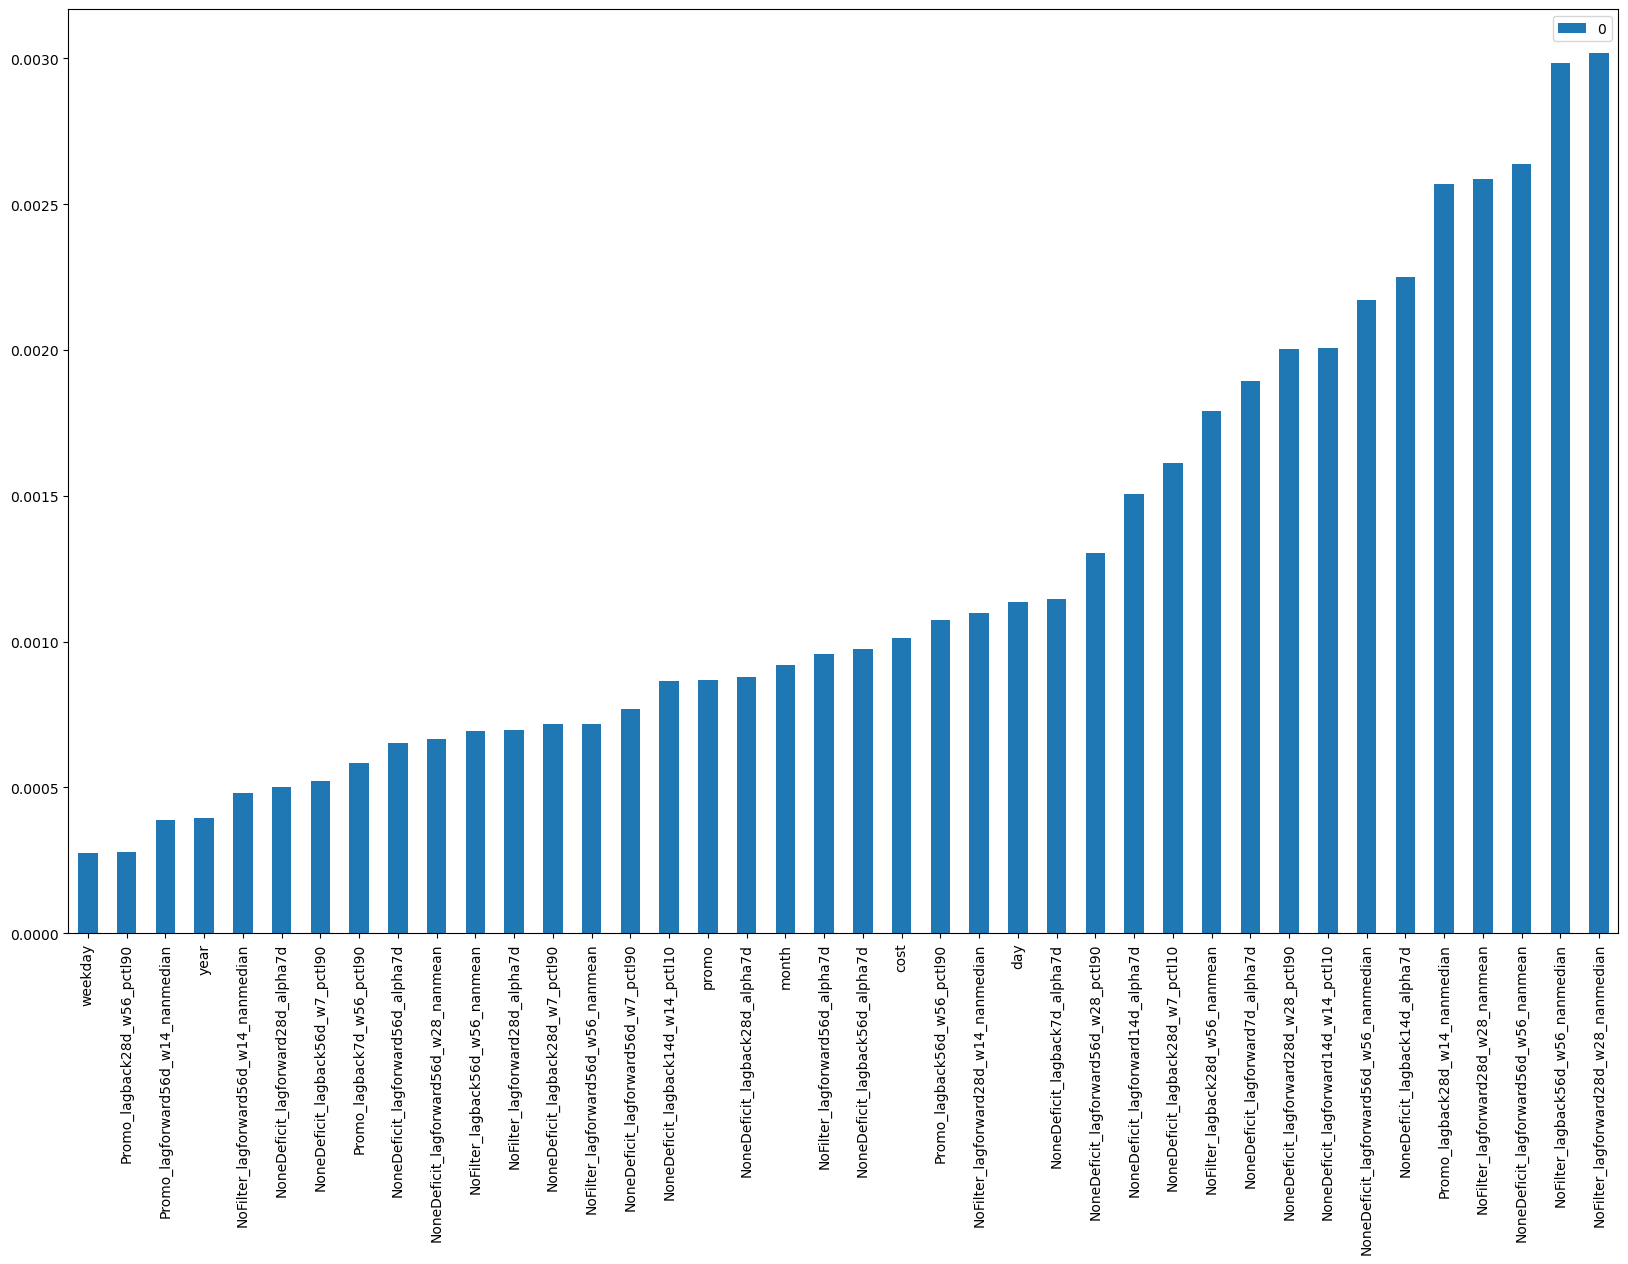

In [881]:
importance_df.plot.bar(figsize=(20,12))

## Сегментация моделей

- кластеризация по городам
- кластеризация по специфике точки продаж
- кластеризация по товарам
- по сочетаниям

Для решения задачи кластеризации можно использовать различные алгоритмы, такие как KMeans, DBSCAN, Hierarchical Clustering и т.д. В данном примере я буду использовать алгоритм KMeans с помощью библиотеки scikit-learn.

### KMeans

In [882]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt



## целевая переменная - спрос, не дельта
## по многим лаговым фичам - на нескольних
## отнормировать 
## 

## попробовать другие сегментации

def kmeans_clustering(df, field_of_clustering, kmean_number, clustering_features): 
    df_clustered = df[field_of_clustering + clustering_features][(df.Deficit == 0)]
    
    
    df_clustered = df_clustered.groupby(field_of_clustering).mean().reset_index()
    
    
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_clustered.iloc[:,1:])
    
    
    kmeans = KMeans(n_clusters=kmean_number)
    kmeans.fit(df_scaled)
    
    print("Quality of clustering %0.2f" % silhouette_score(df_scaled, kmeans.labels_))
    
    df_clustered['cluster'] = kmeans.labels_
    df_clustered = pd.merge(df, df_clustered[field_of_clustering+['cluster']], on=field_of_clustering)
    clusters_kmeans = sorted(list(df_clustered.cluster.unique()))
    return  df_clustered, clusters_kmeans, kmeans.inertia_, kmeans.cluster_centers_

Затем можно определить оптимальное количество кластеров с помощью метода "локтя" (elbow method). Для этого можно циклически изменять количество кластеров и записывать значения inertia_ (метрика, для определения качества кластеризации), а затем построить график зависимости inertia_ от количества кластеров. На этом графике можно найти точку "локтя", которая определяет оптимальное количество кластеров:

In [883]:
clustering_features = numeric + ['sales_qty', 'promo']
#clustering_features = ['NoFilter_lagback7d_w28_nanmean', 'cost']

Quality of clustering 0.55
Quality of clustering 0.29
Quality of clustering 0.26
Quality of clustering 0.27
Quality of clustering 0.22
Quality of clustering 0.20
Quality of clustering 0.14
Quality of clustering 0.14
Quality of clustering 0.13
Quality of clustering 0.11
Quality of clustering 0.09
Quality of clustering 0.08


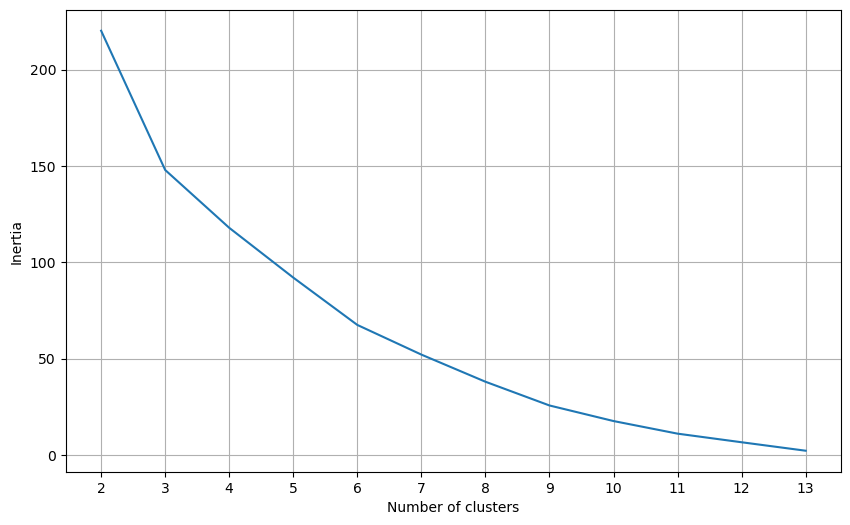

In [884]:
import matplotlib.pyplot as plt

inertia = []
for k in range(2, 14):
    kmeans = kmeans_clustering(df_train_demand, ['location_id'], k, clustering_features)[2]
    inertia.append(kmeans)

x = np.array(range(2,14))
plt.figure(figsize=(10,6)).set_figheight(6)
plt.plot(x, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.xticks(x)
plt.show()


In [893]:
# кластеризация по локации

clustering = kmeans_clustering(df_train_demand, ['location_id'], 3, clustering_features)

clustered_df_location = clustering[0].sample(frac=1).reset_index(drop=True)
centers = clustering[3]

# кластеризация по товару
#clustered_df_product = kmeans_clustering(df_train_demand, ['product_id'], 3, clustering_features)[0].sample(frac=1).reset_index(drop=True)

Quality of clustering 0.29


In [894]:
"""inertia = []
for k in range(2, 6):
    kmeans = kmeans_clustering(df_train_demand, ['product_id'], k, clustering_features)[2]
    inertia.append(kmeans)

x = np.array(range(2,6))
plt.figure(figsize=(10,6)).set_figheight(6)
plt.plot(x, inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid()
plt.xticks(x)
plt.show()

"""

"inertia = []\nfor k in range(2, 6):\n    kmeans = kmeans_clustering(df_train_demand, ['product_id'], k, clustering_features)[2]\n    inertia.append(kmeans)\n\nx = np.array(range(2,6))\nplt.figure(figsize=(10,6)).set_figheight(6)\nplt.plot(x, inertia)\nplt.xlabel('Number of clusters')\nplt.ylabel('Inertia')\nplt.grid()\nplt.xticks(x)\nplt.show()\n\n"

In [898]:
columns=["Demand", 'date', 'sales_qty', 'stock_qty', 'Promo',
                                  'Deficit', 'NoFilter', 'NoneDeficit', 'product_id', 'location_id']



print("Ridge\n")

print("\n\nОбщее обучение:\n")
# linear regression
## общее обучение
massive_training(clustered_df_product[(clustered_df_product.Deficit == 0)], xgb.XGBRegressor(**study.best_trial.params))




Ridge



Общее обучение:

MAE: 0.001
R2: -0.635
MAPE_: 547.894
SMAPE_: 148.670
RMSE_: 0.006
WAPE_: 127.495


In [276]:
# с кластеризацией
print("Результ с кластеризацией по локации:")
input_df = clustered_df_location[(clustered_df_location.Deficit == 0)]
xbgboost_train(input_df, columns)


# без кластеризации
print("\n\nРезульт без кластеризации по локации:")
input_df = clustered_df_location[(clustered_df_location.Deficit == 0)].drop('cluster', axis=1)
xbgboost_train(input_df, columns)

Результ с кластеризацией по локации:
MAE: 0.001
R2: -0.841
MAPE: 215.949
sMAPE: 153.729
RMSE: 0.008


Результ без кластеризации по локации:
MAE: 0.001
R2: -1.103
MAPE: 291.656
sMAPE: 149.981
RMSE: 0.008


In [508]:
centers

array([[-0.64303688,  0.49133168,  0.61808496,  0.43120918,  0.60405264,
         0.57880365,  0.34677048,  0.55830914, -0.1051716 ,  0.68510879,
        -0.06210269,  0.39125979,  0.64300845,  0.4283048 ,  0.63868486,
         0.26054174,  0.60872057,  0.23435837,  0.52451498, -0.23725726,
        -0.19807079],
       [ 2.71875883, -0.21869949, -2.74047385, -0.45778258,  0.56338474,
        -2.10850189,  1.25551549, -2.84956417,  1.45162285, -3.03296713,
         0.1416596 , -0.16082759, -2.8831025 , -0.95206768, -2.82741993,
        -2.19910415, -2.81843799, -1.26615374, -2.8010509 ,  3.39028714,
        -1.60340792],
       [ 0.32877568, -0.45035203, -0.3023883 , -0.36676072, -0.64284198,
        -0.33222118, -0.46890534, -0.23305908, -0.05411555, -0.33567986,
         0.04470692, -0.36005469, -0.31114003, -0.31100095, -0.31293683,
        -0.01561837, -0.28500505, -0.0903291 , -0.20566971, -0.13446126,
         0.36279054]])

#### Визуализация kmeans

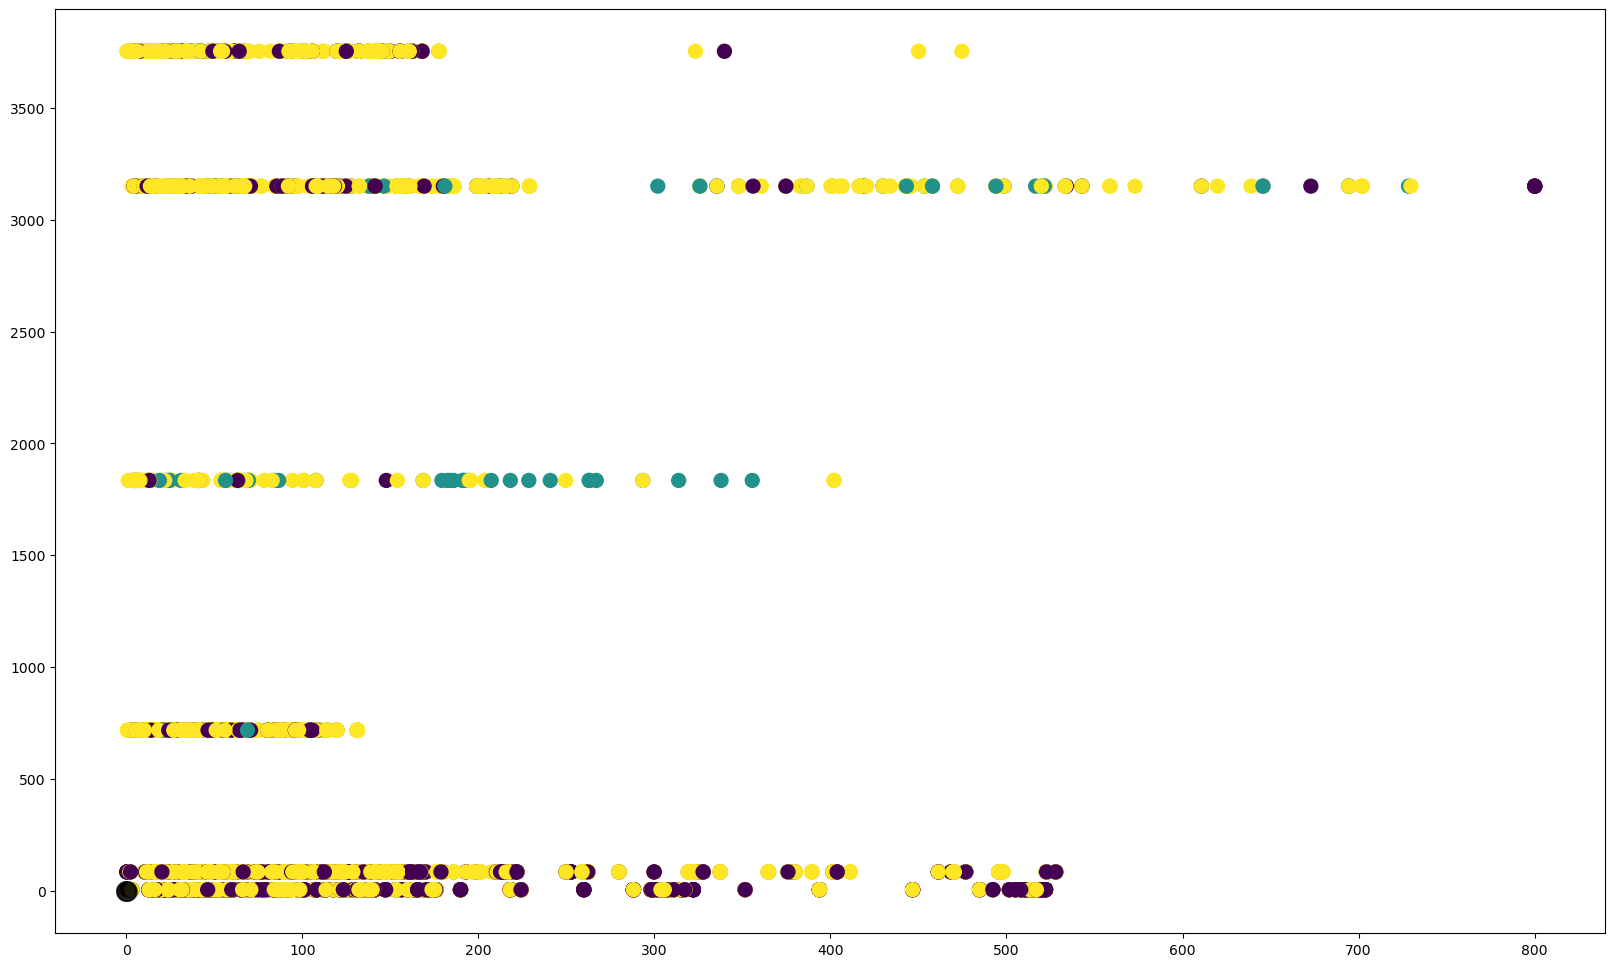

In [507]:
a = clustered_df_location.NoFilter_lagback7d_w28_nanmean
b = clustered_df_location.cost
y_kmeans = clustered_df_location.cluster


plt.figure(figsize=(20,12))
plt.scatter(a,b, c=y_kmeans, s=100, cmap='viridis')
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=200, alpha=0.5);
plt.show()


In [303]:
 clustered_df_location[['sales_qty', 'NoFilter_lagback7d_w28_nanmean', 'Deficit']]

,sales_qty,NoFilter_lagback7d_w28_nanmean,Deficit
0,0.000415,0.016827,0
1,0.000622,0.082870,0
2,0.003109,0.044590,0
3,0.000622,0.069139,0
4,0.000622,0.160730,0
...,...,...,...
22065,0.003109,0.074630,0
22066,0.004975,0.122478,0
22067,0.001036,0.262676,0
22068,0.005182,0.175504,0


### DBSCAN

DBSCAN - это алгоритм кластеризации, который основывается на определении связей между точками в пространстве признаков. DBSCAN может использоваться для выделения выбросов и аномалий в данных, а также для кластеризации временных рядов по группам сходных форм и паттернов.

In [437]:
dbscan_df = df_train_demand.copy()

features = numeric + ['sales_qty', 'promo']
X = dbscan_df[features]

# Стандартизируем признаки
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Задаем eps и min_samples
eps = 2.5
min_samples = 10

# Кластеризуем данные
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(X_scaled)

# Добавляем кластеры в исходный набор данных
dbscan_df['cluster'] = clusters

In [438]:
len(dbscan_df.cluster.unique())

60

In [447]:
smape = []
from tqdm import tqdm

columns=["Demand", 'date', 'sales_qty', 'stock_qty', 'Promo',
                                  'Deficit', 'NoFilter', 'NoneDeficit', 'product_id', 'location_id']

for i in tqdm(range(60)):
    if len(dbscan_df[dbscan_df.cluster == i]) >= 5:
        print(xbgboost_train(dbscan_df[dbscan_df.cluster == i], columns))
        smape += xbgboost_train(dbscan_df[dbscan_df.cluster == i], columns)

  0%|                                                    | 0/60 [00:00<?, ?it/s]

10.72695977218172


  0%|                                                    | 0/60 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [446]:
smape

array([], dtype=float64)